In [1]:
import os
import pandas as pd
from IPython.display import display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
from matplotlib import pyplot as plt
import joblib
import pickle 

from MyTransformers import *
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import inv_boxcox
import seaborn as sns

#%config Completer.use_jedi = False
%matplotlib inline  

f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

In [2]:
def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return loss

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [88]:
from mimetypes import init


def AgregateDiffs(xdiff, start=0):
    return (xdiff.cumsum() + start)
n=48
def plot_series(series, y=None, y_pred=None, _n=n, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(_n, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(_n, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    #plt.axis([0, _n + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

def plot_multiple_forecasts(X, Y, Y_pred, _n=n, toAgregate=False):
    n_steps = len(X)
    ahead = len(Y)
    # if toAgregate:
    #     X = AgregateDiffs(X).reshape(-1,n_steps,1)
    #     Y = AgregateDiffs(Y,X[:,-1]).reshape(-1,ahead,1)
    #     Y_pred = AgregateDiffs(Y_pred,X[:,-1]).reshape(-1,ahead,1)

    # plot_series(X[0, :, 0],_n=n)
    # plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    # plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plot_series(X,_n=n)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y, "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, "rx-", label="Forecast", markersize=10)

    #plt.axis([0, n_steps + ahead, X.min(), X.max()])
    plt.legend(fontsize=14)

def BatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    y_train = time_series[:int(l*TVT_slit[0])                  , -pred_n:, 0].reshape(-1,pred_n,1)
    y_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n:, 0].reshape(-1,pred_n,1)
    y_test  = time_series[int(l*TVT_slit[1]):                  , -pred_n:, 0].reshape(-1,pred_n,1)
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        X_other_train = other_data[:int(l*TVT_slit[0])                  , -pred_n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), -pred_n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , -pred_n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
def OverlapingBatchWithNLen(n,pred_n,time_series, other_data=[],TVT_slit=(0.7,0.9)):
    if len(time_series) % n != 0:
        time_series = time_series[:len(time_series) - (len(time_series) % n)]

    dim = 1 if time_series.ndim == 1 else time_series.shape[-1]
    time_series = time_series.reshape(-1,n,dim)
    l = len(time_series)
    X_train = time_series[:int(l*TVT_slit[0])                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)
    X_valid = time_series[int(l*TVT_slit[0]):int(l*TVT_slit[1]), :n-pred_n, 0].reshape(-1,n-pred_n,1) 
    X_test  = time_series[int(l*TVT_slit[1]):                  , :n-pred_n, 0].reshape(-1,n-pred_n,1)

    Y = np.empty((l, n-pred_n, pred_n))
    for step_ahead in range(1, pred_n + 1):
        Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n - pred_n, 0]    
        
    y_train = Y[:int(l*TVT_slit[0])                  ]
    y_valid = Y[int(l*TVT_slit[0]):int(l*TVT_slit[1])]
    y_test  = Y[int(l*TVT_slit[1]):                  ]
    
    if len(other_data) > 0:
        if len(other_data) % n != 0:
           other_data = other_data[:len(other_data) - (len(other_data) % n)]

        dim = 1 if other_data.ndim == 1 else other_data.shape[-1]
        other_data = other_data.reshape(-1,n,dim)
        # X_other = np.empty((l, n-n_feature,n_feature, len(other_features)))
        # for step_ahead in range(1, pred_n + 1):
            # X_other[..., step_ahead - 1, :] = b[..., step_ahead:step_ahead + n - n_feature, 1:]
        # X_other_train = X_other[:int(l*0.7)           , ...]
        # X_other_valid = X_other[int(l*0.7):int(l*0.9) , ...]
        # X_other_test  = X_other[int(l*0.9):           , ...]

        X_other_train = other_data[:int(l*TVT_slit[0])                  , pred_n:n, :]
        X_other_valid = other_data[int(l*TVT_slit[0]):int(l*TVT_slit[1]), pred_n:n, :]
        X_other_test  = other_data[int(l*TVT_slit[1]):                  , pred_n:n, :]
        return (X_train, y_train, X_other_train), (X_valid, y_valid, X_other_valid) , (X_test, y_test, X_other_test)
    return (X_train, y_train), (X_valid, y_valid) , (X_test, y_test)
    
class MyLoader:
    def __init__(self,files,batchSize,timeSeriesLables, otherDataLabels,splitFun, sumInN = 1, asDiff = False, asSum = False, asBoxcox=False,
                TVT_split=(0.7,0.9),diffLags=[1],pred_n = 10,lable="default"):
        self.batchSize = batchSize
        self.timeSeriesLables = timeSeriesLables
        self.otherDataLabels = otherDataLabels
        self.sumInN = sumInN
        self.asDiff = asDiff
        self.asSum = asSum
        self.asBoxcox = asBoxcox
        self.files = files
        self.TVT_split = TVT_split
        self.diffLags = diffLags
        self.pred_n = pred_n
        self.splitFun = splitFun
        self.lable = lable

    def loadDataTimeSeries(self, files):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(self.timeSeriesLables)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[self.timeSeriesLables].values
            if self.asSum:
                data = data[:len(data) - (len(data) % self.sumInN)]
                if len(self.timeSeriesLables) > 1:
                    data = data.reshape(-1,self.sumInN,len(self.timeSeriesLables))     
                else:
                    data = data.reshape(-1,self.sumInN)
                data = data.sum(axis=1,keepdims=True)

            if self.asBoxcox:
                data , self.boxcoxLambda = stats.boxcox(data.flatten())
                data = data.reshape(-1,1)

            if self.asDiff:
                self.diffInitVals = []
                for lag in self.diffLags:
                    self.diffInitVals.append(data[:lag].flatten())
                    data = data[lag:] - data[:-lag]
                #data = data[1:]

            tmpArr[i] = data[:len(data) - (len(data) % self.batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def loadDataOther(files, features, batchSize):
        tmpArr = [[]]*len(files)
        dataOut = np.empty((0,len(features)))
        for i,file in enumerate(files):
            progres_bar(i + 1,len(files))
            data = pd.read_feather(file)
            data = data[features].values
            tmpArr[i] = data[:len(data) - (len(data) % batchSize)]
        if len(files) > 0:    
            dataOut = np.row_stack(tmpArr)
        else:
            dataOut = tmpArr[0]
        return dataOut.astype('f4')

    def load(self):
        self.timeSeries = self.loadDataTimeSeries(self.files)
        if self.hasOther():
            self.otherData = MyLoader.loadDataOther(self.files, self.otherDataLabels, self.batchSize)
            (self.XTrain, self.YTrain, self.XOtherTrain), (self.XValid, self.YValid, self.XOtherValid), (self.XTest, self.YTest, self.XOtherTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, self.otherData, self.TVT_split)
        else:
            (self.XTrain, self.YTrain), (self.XValid, self.YValid), (self.XTest, self.YTest) = self.splitFun(self.batchSize,self.pred_n,self.timeSeries, [], self.TVT_split)

    def hasOther(self):
        return True if self.otherDataLabels else False
    
    def setArgs(self,args):
        self.args = args
    
    def diffInvers(self,arr,isXInitVals=True):
        if isXInitVals: InitVals = self.diffInitVals
        else: InitVals = self.diffYInitVals

        if isXInitVals:
            self.diffYInitVals = []
        for k,lag in enumerate(self.diffLags):
            cc = np.empty(len(arr)+lag)
            for i in range(lag):  
                cc[i::lag] = np.cumsum(np.concatenate([[InitVals[k][i]],arr[i::lag]]))  
            arr = cc
            if isXInitVals:
                self.diffYInitVals.append(arr[-lag:])
        return arr

class MyModel:
    _model = None
    _lableDefined = False
    _dataLoaded = False
    _trainingStarted = False
    _epoch = 0
    def __init__(self, batchSize, loader,lable,createModel,modelArgs,modleDims,predDataFun):
        self.batchSize = batchSize
        self.loader = loader
        self._lable = lable
        self.createModel = createModel
        self.modelArgs = modelArgs
        self.modleDims = modleDims
        self.predDataFun = predDataFun

    def load(self):
        if not self._dataLoaded:
            self.loader.load() 
            self._dataLoaded = True
        
    def model(self):
        if self._model == None:
            dim = 1 if self.loader.timeSeries.ndim == 1 else self.loader.timeSeries.shape[-1]
            if self.loader.hasOther():
                dim = [dim, 1 if self.loader.otherData.ndim == 1 else self.loader.otherData.shape[-1]]
            self.loader.setArgs(self.modelArgs)
            self._model = self.createModel(self.batchSize,dim,self.modelArgs, self.modleDims)
        return self._model

    def lable(self):
        if not self._lableDefined:
            for i in range(len(self.modleDims)):
                self._lable += f"-{self.modleDims[i]}" 
            self._lable += '-Batch-'+ str(self.batchSize)
            self._lableDefined = True
        return self._lable

    def prepModel(self, loss='mse', optimizer='adam', learningRate=0.01):
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        self.model().compile(loss=loss, optimizer=opt)
        self.tbCallBack = keras.callbacks.TensorBoard(log_dir=f'./Graph/{self.loader.lable}/n{self.batchSize}/{optimizer}-LeRate-{learningRate}-loss-{loss}/{self.lable()}', histogram_freq=0, write_graph=True, write_images=True)
        self.earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20,min_delta=0, restore_best_weights=True)

    def train(self,epochs,loss='mse', optimizer='adam', learningRate=0.01, batch_size=4, isEarlyStoping=True, isSaveTensorBoard=True,**kwargs):
        if not self._trainingStarted:
            self.load()
            self.prepModel(loss,optimizer,learningRate)
            self.history = []
            self.trainData , self.validData, self.testData = self.predDataFun(self.loader)
            self._trainingStarted = True

        callbacks = []
        if isSaveTensorBoard: callbacks.append(self.tbCallBack)
        if isEarlyStoping: callbacks.append(self.earlyStopCallback) 

        self.history.append(self.model().fit(self.trainData[0], self.trainData[1], epochs=epochs,batch_size=batch_size,
        validation_data=self.validData,callbacks=callbacks,**kwargs))
        print("Done Fiting.")
        self._epoch += epochs
      
    def test(self,plotsCount=5,batchStart=1,random=False):
        batchs = range(batchStart,batchStart + plotsCount)
        if random:
            batchs = np.round(np.random.rand(plotsCount) * (len(self.testData[1])-1)).astype('i4')
        for batch in batchs:
            print(batch)
            if self.loader.hasOther():
                X_new = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X_new[i] = vec[batch:batch+1]
            else:
                X_new = self.testData[0][0][batch:batch+1]

            Y_new = self.testData[1][batch:batch+1]
            if self.loader.splitFun == OverlapingBatchWithNLen:
                Y_pred = self.model().predict(X_new)[:, -self.loader.pred_n:]
                Y_new = Y_new[:, -self.loader.pred_n:]
            elif self.loader.splitFun == BatchWithNLen:
                Y_pred = self.model().predict(X_new).reshape(1,self.loader.pred_n,1)
            else: print("what")

            if self.loader.hasOther():
                X = X_new[0]
            else:
                X = X_new
            
            if self.loader.asBoxcox:
                X = inv_boxcox(X,self.loader.boxcoxLambda)
                Y_new = inv_boxcox(Y_new,self.loader.boxcoxLambda)
                Y_pred = inv_boxcox(Y_pred,self.loader.boxcoxLambda)
            
            X = X[0,:,0]
            Y_new = Y_new[0,:,0]
            Y_pred = Y_pred[0,:,0]
            if self.loader.asDiff:
                X = self.loader.diffInvers(X)
                Y_new = self.loader.diffInvers(Y_new,False)
                Y_pred = self.loader.diffInvers(Y_pred,False)

            plot_multiple_forecasts(X, Y_new, Y_pred,_n=self.batchSize, toAgregate=self.loader.asDiff)
            plt.figure()

    def save(self):
        self.model().save(mode_path + f'{self.lable()}-epoch-{self._epoch}')

    def testResult(self, show=False):
        l = len(self.testData[1])
        l_pSum = np.zeros(l); l_ySum = np.zeros(l); l_diff = np.zeros(l); l_prec = np.zeros(l); l_mse = np.zeros(l)
        l_rmspe = np.zeros(l); l_mape = np.zeros(l)
        pSize = self.loader.pred_n + (0 if not self.loader.asDiff else np.sum(self.loader.diffLags)) 
        l_Y = np.zeros((l,pSize)); l_pred = np.zeros((l,pSize))
        for j in range(l):
            if self.loader.hasOther():
                X = [[]]*len(self.testData[0])
                for i,vec in enumerate(self.testData[0]):
                    X[i] = vec[j:j+1]
            else:
                X = self.testData[0][0][j:j+1]
            Y = self.testData[1][j:j+1]

            if self.loader.splitFun == OverlapingBatchWithNLen:
                pred = self.model().predict(X)[:, -1:].reshape(self.loader.pred_n)
                Y = Y[-1,-1]
            elif self.loader.splitFun == BatchWithNLen:
                pred = self.model().predict(X).reshape(self.loader.pred_n)
                Y = Y.reshape(self.loader.pred_n)
            else: 
                print("what")
                print(self.loader.splitFun,OverlapingBatchWithNLen,BatchWithNLen)
            if self.loader.asDiff:
                X = self.loader.diffInvers(X[0,:,0])
                pred = self.loader.diffInvers(pred,False)
                Y = self.loader.diffInvers(Y,False)
            if self.loader.asBoxcox:
                pred = inv_boxcox(pred,self.loader.boxcoxLambda)
                Y = inv_boxcox(Y,self.loader.boxcoxLambda)
            l_pSum[j] = pred.sum()
            l_ySum[j] = Y.sum()
            l_diff[j] = l_ySum[j] - l_pSum[j]
            l_prec[j] = ((l_diff[j] / l_ySum[j]) * 100)
            l_mse[j] = (mean_squared_error(Y,pred))
            l_rmspe[j] = rmspe(Y,pred)
            l_mape[j] = mape(Y,pred)
            l_Y[j] = Y
            l_pred[j] = pred.copy()
            if show:
                print(f"predSum: {l_pSum[j]: .4f} YSum: {l_ySum[j]: .4f} diff: {l_diff[j]: .4f} precent: {l_prec[j]: .4f}% \t mse: {l_mse[j]: .4f} rmspe: {l_rmspe[j]: .4f} mape: {l_mape[j]: .4f}") 
        return l_pSum, l_ySum, l_diff, l_prec, l_mse, l_rmspe, l_mape, l_Y, l_pred


In [10]:
LPG = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=1,
    lable="LPG")

LPG10 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    pred_n=10,
    lable="LPG10")

LPGO10 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    pred_n=10,
    lable="LPGO10")

LPG8 = MyLoader(
    files=[f_data_path + "LPG-Profile-0.feather"],
    batchSize=16,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    pred_n=8,
    lable="LPGO10")

Lond = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=BatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=True,
    pred_n=1,
    lable="Lond")

LondO = MyLoader(
    files=[f_HHData + id for id in os.listdir(f_HHData)[:1]],
    batchSize=48,
    timeSeriesLables=['energy'],
    otherDataLabels=['temperature', 'holiday_ind', 'Acorn_category', 'dayPrecent','yearPrecent', 'pastET'],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=False,
    asDiff=False,
    pred_n=10,
    lable="LondO10")


In [5]:
def createFlattenModel(batchSize,timeSDim,args,dims): #batchSize, Dims
          return keras.models.Sequential([
            keras.layers.Flatten(input_shape=[batchSize-dims[-1], timeSDim]),
            keras.layers.Dense(dims[-1])])
def predDataDefault(l):
    return ([l.XTrain],l.YTrain),([l.XValid], l.YValid),[[l.XTest],l.YTest]
        
def predDataConv(l):
    return ([l.XTrain],l.YTrain[:,(l.args[0]-1)::l.args[1]]),([l.XValid], l.YValid[:,(l.args[0]-1)::l.args[1]]),[[l.XTest],l.YTest[:,(l.args[0]-1)::l.args[1]]]
        
def predDataWithOther(l):
    return ([l.XTrain,l.XOtherTrain],l.YTrain),([l.XValid,l.XOtherValid], l.YValid),[[l.XTest,l.XOtherTest],l.YTest]

    X_train, Y_train[:,(k_size-1)::stride]
        
def createSimpleRNN (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.SimpleRNN(dims[-1]))
    return m

def createSimpleRNNTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createSimpleRNNWithOtherData(batchSize, dataDim, args, dims):
    input_A = keras.layers.Input(shape=[None, dataDim[0]], name="Time-series")
    input_B = keras.layers.Input(shape=[dataDim[1]], name="other")
    hidden1 = keras.layers.SimpleRNN(dims[0], return_sequences=True)(input_A)
    for i in range(1,len(dims)-2):
        hidden1 = keras.layers.SimpleRNN(dims[i], return_sequences=True)(hidden1)
    hidden2 = keras.layers.SimpleRNN(dims[-2], return_sequences=False)(hidden1)
    hidden3 = keras.layers.Dense(dims[-1])(hidden2)
    concat = keras.layers.concatenate([input_B, hidden3])
    output = keras.layers.Dense(dims[-1], name="output")(concat)
    return keras.Model(inputs=[input_A, input_B], outputs=[output])

def createLSTMWithOtherData(batchSize, dataDim, args, dims):
    input_A = keras.layers.Input(shape=[None, dataDim[0]], name="Time-series")
    input_B = keras.layers.Input(shape=[None,dataDim[1]], name="other")
    hidden1 = keras.layers.LSTM(dims[0], return_sequences=True)(input_A)
    for i in range(1,len(dims)-2):
        hidden1 = keras.layers.LSTM(dims[i], return_sequences=True)(hidden1)
    hidden2 = keras.layers.LSTM(20, return_sequences=True)(hidden1)
    hidden3 = keras.layers.TimeDistributed(keras.layers.Dense(dims[-1]))(hidden2)
    hidden4 = keras.layers.TimeDistributed(keras.layers.Dense(dims[-1]))(input_B)
    concat  = keras.layers.concatenate([hidden4, hidden3],axis=2)
    output  = keras.layers.Dense(1, name="output")(concat)
    return keras.Model(inputs=[input_A, input_B], outputs=[output])

def createSimpleRNNWithBatchNorm(batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.SimpleRNN(dims[-1]))
    return m

def createSimpleRNNWithBatchNormTimeDist(batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.SimpleRNN(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.SimpleRNN(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTM (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.LSTM(dims[i], return_sequences=True)) for i in range(1,len(dims)-2)]
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.LSTM(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createGRU (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.GRU(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createGRUTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.GRU(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(1,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createConvGRU (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.Conv1D(filters=dims[0], kernel_size=args[0], strides=args[1], padding="valid",input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(0,len(dims)-1)]
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createConvGRUTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.Conv1D(filters=dims[0], kernel_size=args[0], strides=args[1], padding="valid",input_shape=[None, timeSDim]))
    [m.add(keras.layers.GRU(dims[i], return_sequences=True)) for i in range(0,len(dims)-1)]
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTMBatchNormDrop (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    for i in range(1,len(dims)-2):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
        m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMBatchNormDropTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dropout(rate=args[0]))
    for i in range(1,len(dims)-1):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
        m.add(keras.layers.Dropout(rate=args[0]))
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m

def createLSTMBatchNorm (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-2):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.LSTM(dims[-2], return_sequences=False))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.Dense(dims[-1]))
    return m

def createLSTMBatchNormTimeDist (batchSize, timeSDim, args, dims): 
    m = keras.models.Sequential()
    m.add(keras.layers.LSTM(dims[0], return_sequences=True, input_shape=[None, timeSDim]))
    m.add(keras.layers.BatchNormalization())
    for i in range(1,len(dims)-1):
        m.add(keras.layers.LSTM(dims[i], return_sequences=True))
        m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.TimeDistributed(keras.layers.Dense(dims[-1])))
    return m



In [6]:
def createWaveNet (batchSize, timeSDim, args=[20,4,2,2,'relu'], dims=[10]): 
    m = keras.models.Sequential()
    m.add(keras.layers.InputLayer(input_shape=[None, timeSDim]))
    for rate in [2**i for i in range(args[1])] * args[2]:
        m.add(keras.layers.Conv1D(filters=args[0], kernel_size=args[3], padding="causal", activation=args[4], dilation_rate=rate))
    m.add(keras.layers.Conv1D(filters=dims[-1], kernel_size=1))
    return m

In [7]:
Flatten = MyModel(
    batchSize=48,
    loader=LPG,
    lable="Flatten",
    createModel=createFlattenModel,
    modelArgs=[],
    modleDims=[48,1],
    predDataFun=predDataDefault
)
SimpleRNNWithOtherData = MyModel(
    batchSize=48,
    loader=LondO,
    lable="SimpleRNNWithOther",
    createModel=createLSTMWithOtherData,
    modelArgs=[],
    modleDims=[20,20,10],
    predDataFun=predDataWithOther
)


In [89]:
LPG = MyLoader(
    files=[f_data_path + "LPG-Profile-4.feather"],
    batchSize=56,
    timeSeriesLables=['energy'],
    otherDataLabels=[],
    splitFun=OverlapingBatchWithNLen,
    sumInN=60*3,
    asSum=True,
    asDiff=True,
    diffLags=[1,4],
    asBoxcox=False,
    pred_n=16,
    lable="LPGO10")

# LSTMBatchNormDrop = MyModel(
#     batchSize=56,
#     loader=LPG,
#     lable="WaveNet",
#     createModel=createWaveNet,
#     modelArgs=[20,6,2,3,'relu'],
#     modleDims=[16],
#     predDataFun=predDataDefault
# )

LSTMBatchNormDrop = MyModel(
    batchSize=56,
    loader=LPG,
    lable="WaveNet",
    createModel=createLSTMTimeDist,
    modelArgs=[],
    modleDims=[112,56,28,16],
    predDataFun=predDataDefault
)



In [90]:
np.random.seed(42)
tf.random.set_seed(42)
LSTMBatchNormDrop.train(10,learningRate=0.01,isEarlyStoping=True,batch_size=16,isSaveTensorBoard=False)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Epoch 1/10
7/7 [==============================] - 8s 281ms/step - loss: 3.2732 - val_loss: 3.1953
Epoch 2/10
7/7 [==============================] - 0s 42ms/step - loss: 3.0662 - val_loss: 2.9958
Epoch 3/10
7/7 [==============================] - 0s 41ms/step - loss: 2.9060 - val_loss: 2.9232
Epoch 4/10
7/7 [==============================] - 0s 43ms/step - loss: 2.8466 - val_loss: 2.8702
Epoch 5/10
7/7 [==============================] - 0s 41ms/step - loss: 2.7871 - val_loss: 2.8237
Epoch 6/10
7/7 [==============================] - 0s 41ms/step - loss: 2.7143 - val_loss: 2.7692
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 2.6408 - val_loss: 2.5854
Epoch 8/10
7/7 [==============================] - ETA: 0s - loss: 2.560 - 0s 45ms/step - loss: 2.5606 - val_loss: 2.5444
Epoch 9/10
7/7 [==============================] - 0s 44ms/step - loss: 2.5484 - val_loss

In [14]:
LSTMBatchNormDrop.save()

INFO:tensorflow:Assets written to: Models/WaveNet-112-56-28-16-Batch-56-epoch-200\assets


INFO:tensorflow:Assets written to: Models/WaveNet-112-56-28-16-Batch-56-epoch-200\assets


In [91]:
# import warnings
# warnings.filterwarnings("ignore")
with np.errstate(divide='ignore'):
    x = LSTMBatchNormDrop.testResult(show=True)
pd.DataFrame([np.mean(abs(r)) for r in x][:-2],['predSum','YSum','diff','precent','mse','rmspe','mape']).transpose()

predSum:  14.4152 YSum:  25.2617 diff:  10.8465 precent:  42.9364% 	 mse:  0.5256 rmspe:  0.9786 mape:  59.0162
predSum:  27.6481 YSum:  46.7733 diff:  19.1252 precent:  40.8891% 	 mse:  1.6806 rmspe:  0.6524 mape:  44.5950
predSum: -6.7010 YSum:  16.6398 diff:  23.3408 precent:  140.2712% 	 mse:  1.9977 rmspe:  1.4212 mape:  104.6599
predSum:  59.6348 YSum:  37.4453 diff: -22.1895 precent: -59.2585% 	 mse:  4.9203 rmspe:  0.7415 mape:  41.4149
predSum:  29.6631 YSum:  35.2818 diff:  5.6187 precent:  15.9252% 	 mse:  0.3666 rmspe:  0.3463 mape:  22.7145
predSum:  39.7828 YSum:  39.5093 diff: -0.2735 precent: -0.6923% 	 mse:  0.3382 rmspe:  0.2371 mape:  17.3194
predSum:  17.5258 YSum:  27.7175 diff:  10.1918 precent:  36.7701% 	 mse:  0.6521 rmspe:  0.6703 mape:  43.7051
predSum:  9.8349 YSum:  21.9800 diff:  12.1451 precent:  55.2551% 	 mse:  0.9035 rmspe:  2.4466 mape:  98.6520
predSum: -24.8126 YSum: -18.9910 diff:  5.8216 precent: -30.6546% 	 mse:  0.5272 rmspe:  1.3021 mape:  72.1

,predSum,YSum,diff,precent,mse,rmspe,mape
0,32.741584,32.055822,16.473336,87.118467,1.994817,12.141737,342.671703


In [47]:
x = LSTMBatchNormDrop.testResult(show=True)
pd.DataFrame([np.mean(abs(r)) for r in x][:-2],['predSum','YSum','diff','precent','mse','rmspe','mape']).transpose()

predSum:  12.7208 YSum:  12.7331 diff:  0.0123 precent:  0.0965% 	 mse:  0.1033 rmspe:  0.7814 mape:  56.1065
predSum:  12.6715 YSum:  16.4209 diff:  3.7494 precent:  22.8333% 	 mse:  0.6018 rmspe:  0.6458 mape:  51.1868
predSum:  12.4461 YSum:  11.2750 diff: -1.1711 precent: -10.3865% 	 mse:  0.0675 rmspe:  0.5141 mape:  35.6642
predSum:  13.5589 YSum:  19.5910 diff:  6.0321 precent:  30.7901% 	 mse:  1.1988 rmspe:  0.8066 mape:  54.6077
predSum:  12.5879 YSum:  14.6840 diff:  2.0961 precent:  14.2746% 	 mse:  0.2121 rmspe:  0.5720 mape:  43.9250
predSum:  12.7454 YSum:  12.3998 diff: -0.3456 precent: -2.7868% 	 mse:  0.2267 rmspe:  0.7744 mape:  55.8812
predSum:  12.5811 YSum:  12.0208 diff: -0.5603 precent: -4.6607% 	 mse:  0.0801 rmspe:  0.4850 mape:  40.1416
predSum:  12.7154 YSum:  17.2739 diff:  4.5585 precent:  26.3898% 	 mse:  0.6599 rmspe:  0.5914 mape:  43.5434
predSum:  12.8934 YSum:  15.3271 diff:  2.4337 precent:  15.8781% 	 mse:  1.6366 rmspe:  0.9475 mape:  72.3874
pred

,predSum,YSum,diff,precent,mse,rmspe,mape
0,12.733879,14.868213,2.557118,15.048991,0.568004,0.670723,50.403313


In [15]:
LSTMBatchNormDrop.model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 112)         51072     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 56)          37856     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 28)          9520      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 16)          464       
Total params: 98,912
Trainable params: 98,912
Non-trainable params: 0
_________________________________________________________________


In [65]:
9416*12

112992

0
1
2
3
4
5
6
7
8
9
10


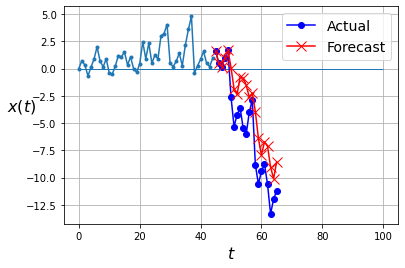

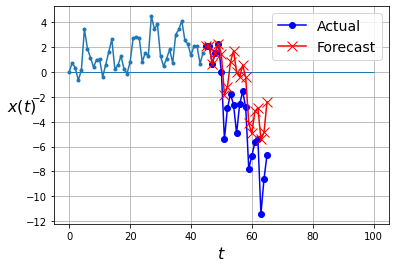

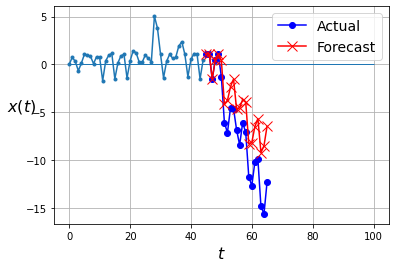

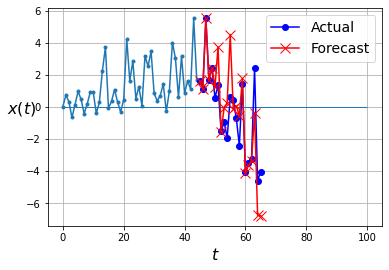

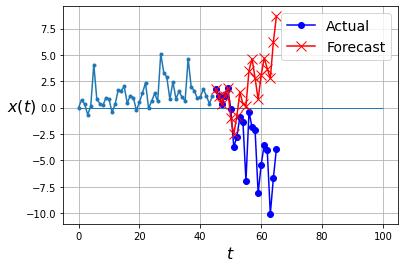

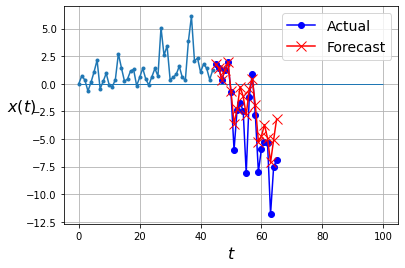

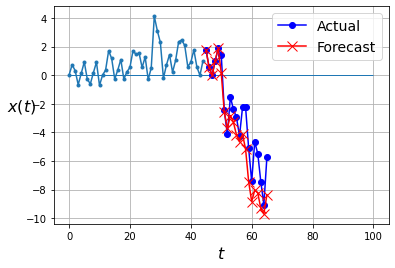

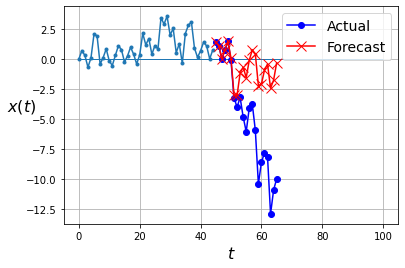

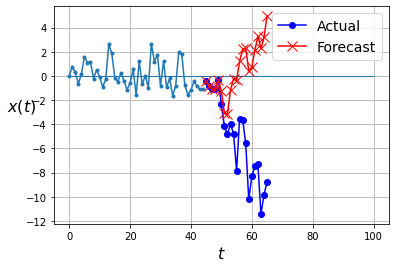

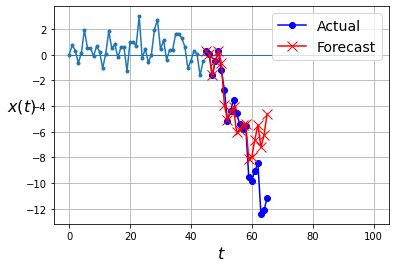

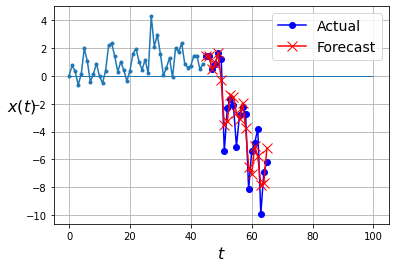

<Figure size 432x288 with 0 Axes>

In [92]:
LSTMBatchNormDrop.test(batchStart=0,plotsCount=11)

In [167]:
import winsound

#sumIn = [60,80,100,120,140,160,180,200,220,240,260,280,300]
sumIn = range(60,12*60,15)
results = []
for i,sumInN in enumerate(sumIn):
    np.random.seed(42)
    tf.random.set_seed(42)
    LPG = MyLoader(
        files=[f_data_path + "LPG-Profile-0.feather"],
        batchSize=int(1440/sumInN)*7,
        timeSeriesLables=['energy'],
        otherDataLabels=[],
        splitFun=OverlapingBatchWithNLen,
        sumInN=sumInN,
        asSum=True,
        asDiff=False,
        pred_n=int(2880 / sumInN),
        lable="LPG16")

    LSTM = MyModel(
        batchSize=int(1440/sumInN)*7,
        loader=LPG,
        lable="ConvGRUEarlyStop",
        createModel=createConvGRUTimeDist,
        modelArgs=[int(2880 / sumInN),int(2880 / sumInN / 4)],
        modleDims=[int(1440/sumInN)*7*2,int(1440/sumInN)*4,int(2880 / sumInN)*3,int(2880 / sumInN)],
        predDataFun=predDataConv
    )

    LSTM.train(400,verbose=0,isSaveTensorBoard=False,isEarlyStoping=True)
    results.append(LSTM.testResult())
    print(f"Testing: {sumInN}")
    progres_bar(i + 1, len(sumIn))

winsound.Beep(1000, 400)


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 60
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 75
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 90
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 105
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 120
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 135
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Done Fiting.
Testing: 150
|███████████████████████████████████████████

In [168]:
rr = [[np.mean(np.abs(r[i])) for i in range(len(r)-2)]for r in results]
rr = np.array(rr)

In [169]:
df = pd.DataFrame(np.abs(rr))
df.columns = ['pred sum', 'Y sum', 'diff', '%', 'mse', 'rmspe', 'mape']
df['sumIn'] = sumIn
df.to_csv("Results/Test_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStopModel_2xmoreNeurons_Diff_seed42_60-720_ConvGru_TimeDistrib.csv")
df

,pred sum,Y sum,diff,%,mse,rmspe,mape,sumIn
0,13.108234,14.868213,2.319676,14.199994,0.105864,0.841857,60.735568,60
1,19.159190,13.586494,5.572696,44.660734,0.196410,2.258998,166.576335,75
2,14.535124,14.868213,2.666389,17.849090,0.172540,0.907760,62.024444,90
3,5.811628,18.662450,12.850823,67.879092,0.782963,0.802580,69.531642,105
4,14.936648,14.868213,2.564233,17.599438,0.268050,0.875283,64.767217,120
5,17.960218,16.848298,2.803270,16.523926,0.683828,1.477441,101.851330,135
6,18.697066,17.279369,2.926855,18.680367,0.715676,1.365048,97.188714,150
7,15.041026,16.700079,6.785056,36.313888,1.484747,1.340503,92.360515,165
8,14.027105,14.868213,2.365553,15.224880,0.495611,0.550201,40.185934,180
9,16.704476,18.349377,3.995083,21.468041,1.115651,1.049154,80.271316,195


In [134]:
pickle.dump(results,open("Results/TestTest_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStopModel_2xmoreNeurons_Diff_seed42_60-720_ConvGru_TimeDistrib.dat", "wb"))

In [56]:
res2 = pickle.load(open("Results/Test_SumInBestTime_BatchScale_ModelDimsAuto_EarlyStop2.dat", "rb"))

In [135]:
df.describe()

,pred sum,Y sum,diff,%,mse,rmspe,mape,sumIn
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,15.690806,16.054395,3.730705,23.599674,3.273871,0.919642,68.335676,382.500000
std,2.058360,1.754833,0.912323,5.812920,2.689484,0.412905,27.936470,192.678489
min,9.545694,13.036545,2.317807,13.821583,0.144054,0.391628,30.758292,60.000000
25%,14.577220,14.868213,3.036023,19.891382,1.072600,0.637844,51.657387,221.250000
50%,15.982593,16.095388,3.683588,23.368475,2.679642,0.793581,60.463131,382.500000
75%,17.138023,17.049122,4.100511,25.509546,4.752659,1.073464,76.813474,543.750000
max,19.052125,20.380038,5.867410,44.276663,10.693435,2.383435,168.273269,705.000000


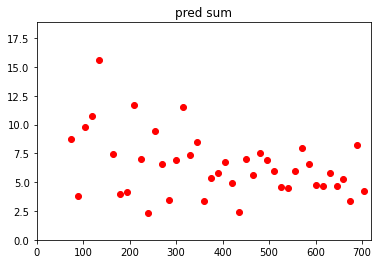

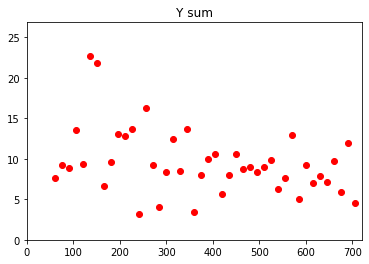

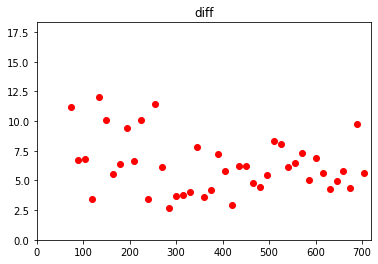

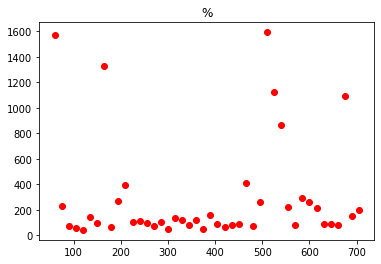

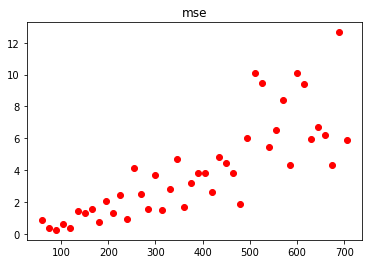

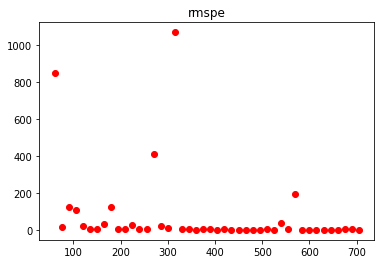

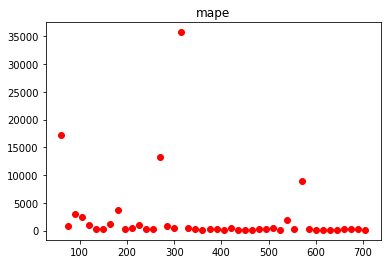

<Figure size 432x288 with 0 Axes>

In [143]:

cols = ['pred sum', 'Y sum', 'diff', '%', 'mse', 'rmspe', 'mape']
for i,col in enumerate(cols):
    plt.plot(sumIn,df[col],"ro")
    if i < 3:
        plt.axis([0, 720
        , 0, df[col].median()*3])
    plt.title(col)
    plt.figure()

In [170]:
y = [r[7] for r in results]
pred = [r[8] for r in results]

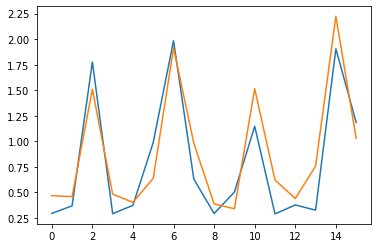

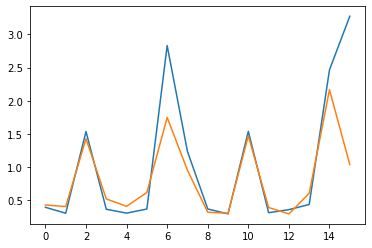

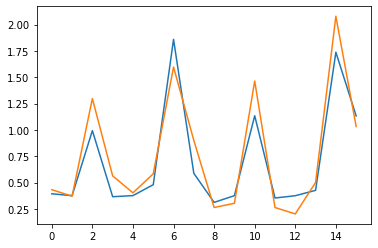

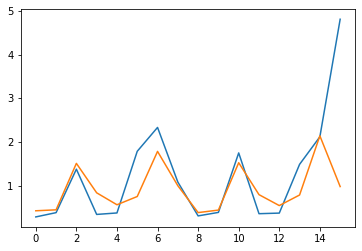

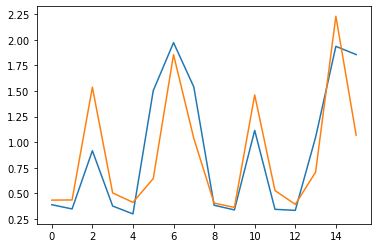

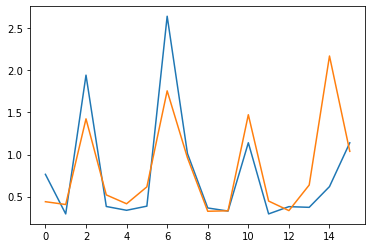

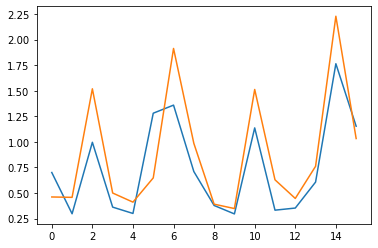

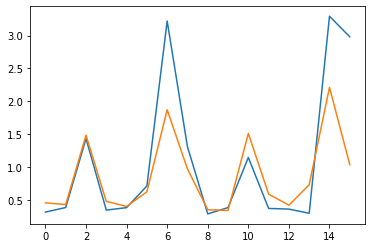

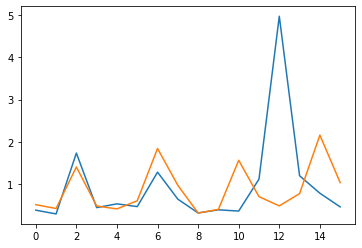

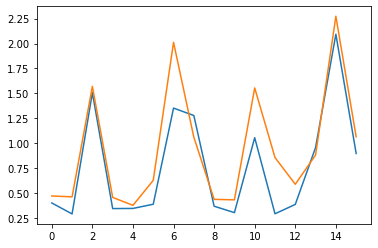

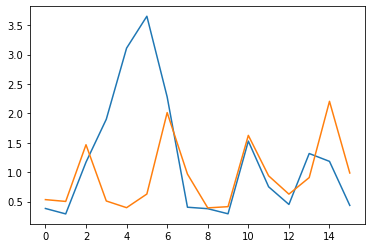

<Figure size 432x288 with 0 Axes>

In [173]:
s = 8

for a,b in zip(y[s],pred[s]):
    plt.plot(a)
    plt.plot(b)
    plt.figure()